We know that the issue is in the custom backprop, so that gives us two lines to focus in one. Let's deconstruct the SBl function so we get the prior and manually figure out which operation is messing it up.

In [1]:
# %% Imports
from jax import numpy as jnp, random
import jax

from modax.data.kdv import doublesoliton
from modax.models import Deepmod
from modax.training.utils import create_update
from flax import optim
from modax.training import train_max_iter
from modax.training.losses.utils import precision, normal_LL


from forward_solver import fixed_point_solver_explicit, fixed_point_solver_implicit, fwd_solver
from SBL import update, evidence, SBL
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Lets first create some fake input the neural network:

# test data

In [2]:
key = random.PRNGKey(42)
x = jnp.linspace(-10, 10, 100)
t = jnp.linspace(0.1, 1.0, 10)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
u = doublesoliton(x_grid, t_grid, c=[5.0, 2.0], x0=[0.0, -5.0])

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.10 * jnp.std(y) * random.normal(key, y.shape)

In [3]:
# %% Building model and params
model = Deepmod([30, 30, 30, 1])
variables = model.init(key, X)

prediction, dt, theta, coeffs = model.apply(variables, X)

In [4]:
n_samples, n_features = theta.shape
prior_params_mse = (0.0, 0.0)
tau = precision(y, prediction, *prior_params_mse)

In [5]:
alpha_prior = (1e-6, 1e-6)
beta_prior = (n_samples / 2, n_samples / (jax.lax.stop_gradient(tau)))
hyper_prior = (alpha_prior, beta_prior)

# Baseline

In [6]:
n_samples, n_features = theta.shape

In [7]:
prior_init = jnp.ones((n_features + 1,))
prior_init = jax.ops.index_update(
        prior_init, n_features, 1 / (jnp.var(dt) + 1e-6)) 
#prior_init = jnp.concatenate([prior_init, jnp.ones((n_features,))], axis=0)


In [8]:
gram = jnp.dot(theta.T, theta)
XT_y = jnp.dot(theta.T, dt)

In [10]:
with jax.disable_jit():
    prior_params, iterations = fixed_point_solver_explicit(
        update,
        (theta, dt, gram, XT_y, hyper_prior),
        prior_init,
        lambda z_prev, z: True,
        max_iter=2000)

Let's check if we have a decent minimum:

In [22]:
jax.grad(lambda a: evidence(theta, dt, gram, XT_y, a, hyper_prior)[0])(prior_params)

DeviceArray([-1.4501247e-12, -3.4814569e-08,  1.9314452e-09,
              1.5473245e-09, -9.7549560e-09,  2.7867371e-09,
              2.8886293e-09, -3.9100545e-10,  1.1769790e-09,
              8.5388621e-09, -3.7124970e-09, -4.0797605e-09,
              1.5258789e-05], dtype=float32)

So yes its a proper minimum. Now if we calculate the derivative of alpha w.r.t to the rest:

In [12]:
with jax.disable_jit():
    explicit_grad = jax.grad(lambda x: fixed_point_solver_explicit(
    update,
    (x, dt, gram, XT_y, (alpha_prior, beta_prior)),
    prior_init,
    lambda z_prev, z: True,
    max_iter=2000)[0][0])(theta)

In [13]:
explicit_grad[0, :]

DeviceArray([ 5.9304049e-04, -2.1750495e-06,  1.0385219e-02,
             -1.2006798e-05,  1.5026473e-01,  8.7360866e-05,
             -4.8979324e-05,  1.2004944e-04,  4.6569319e-05,
              1.2302976e-04,  1.1448472e-04, -7.0657217e-05],            dtype=float32)

In [14]:
prior_params - update(prior_params, theta, dt, gram, XT_y, hyper_prior)

DeviceArray([ 9.76562500e-03,  4.89866943e+01,  0.00000000e+00,
             -1.20390625e+01,  2.38418579e-07, -2.06573486e-01,
             -5.52230835e-01,  1.72668457e-01, -1.38168335e-01,
             -3.54404449e-02,  1.56177521e-01,  4.04167175e-02,
             -2.38418579e-07], dtype=float32)

Okay so we have the gradient using the explicit method - let's try and get the 

In [23]:
_, vjp_z = jax.vjp(lambda z: update(z, theta, dt, gram, XT_y, hyper_prior), prior_params)
_, vjp_a = jax.vjp(lambda x: update(prior_params, x, dt, gram, XT_y, hyper_prior), theta)

In [24]:
z_star_bar = jnp.ones_like(prior_params)
z_star_bar = jax.ops.index_update(z_star_bar, 0, 1)

In [25]:
temp, its = fwd_solver(lambda u: vjp_z(u)[0] + z_star_bar,
        jnp.zeros_like(prior_params),
        lambda z_prev, z: jnp.linalg.norm(z - z_prev) > 1e-6,
        max_iter=2000,
    )

In [26]:
its

DeviceArray(2000, dtype=int32)

In [27]:
vjp_a(temp)[0][0]

DeviceArray([ 8.22197122e-04, -2.94798042e-06,  1.43981995e-02,
             -1.66622140e-05,  2.08328426e-01,  1.21292534e-04,
             -6.80181474e-05,  1.66412952e-04,  6.46140252e-05,
              1.71060718e-04,  1.58225201e-04, -9.78130047e-05],            dtype=float32)

Okay so it goes wrong in the first vjp. Let's check that out a little and then manually perform the calculation?

In [43]:
u = jnp.zeros_like(prior_params)
for idx in jnp.arange(1000):
    u = vjp_z(u)[0] + z_star_bar
    if idx % 100 == 0:
        print(u)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 2.2745152e+00  1.1691406e+01 -2.1374512e+02  3.7730026e-01
 -9.4501680e+03  4.6166992e-01  4.7656250e-01  5.6365967e-01
  5.1293945e-01  5.8007812e-01  5.7519531e-01  5.1513672e-01
  4.4797192e+02]
[ 2.2726221e+00  2.7458594e+02 -2.1399780e+02 -4.1478882e+00
 -9.4632734e+03 -1.6015625e+00 -3.6181641e-01  5.0781250e-02
  5.3503418e-01 -3.5156250e-01  4.4042969e-01  5.6640625e-02
 -1.4795292e+05]
[ 2.22604847e+00  6.71450000e+03 -2.20035889e+02 -1.13640625e+02
 -9.78062793e+03 -5.21875000e+01 -2.08632812e+01 -1.25380859e+01
  1.10690308e+00 -2.30625000e+01 -2.89843750e+00 -1.12656250e+01
 -3.78761050e+06]
[ 1.0856447e+00  1.6440900e+05 -3.6791431e+02 -2.7953438e+03
 -1.7552887e+04 -1.2910000e+03 -5.2287500e+02 -3.2093750e+02
  1.5109375e+01 -5.8300000e+02 -8.4500000e+01 -2.8850000e+02
 -9.2917520e+07]
[-2.6852421e+01  4.0272650e+06 -3.9896338e+03 -6.8477750e+04
 -2.0790072e+05 -3.1623000e+04 -1.2827000e+04 -7.8755000e+03
  3.5775000e+02 -1.41750

Ah so the forward pass overflows... So we know the cause of the Nan. Now to figure out if we do it manually if that also happens

In [28]:
prior_params.shape

(13,)

In [29]:
df1 = jax.jacobian(lambda z: update(z, theta, dt, gram, XT_y, hyper_prior))(prior_params)

In [30]:
part_1 = jnp.linalg.inv(jnp.eye(n_features + 1) - df1)

In [31]:
jnp.dot(z_star_bar, part_1)

DeviceArray([ 2.2745795e+00,  5.1115566e-01, -2.1373224e+02,
              5.0480503e-01, -9.4496387e+03,  5.4992807e-01,
              5.1060414e-01,  5.8732212e-01,  5.1091862e-01,
              6.1729109e-01,  5.8454955e-01,  5.3762561e-01,
              7.0027075e+03], dtype=float32)

In [32]:
vjp_a(jnp.dot(z_star_bar, part_1))[0][0]

DeviceArray([ 8.22147238e-04, -2.94780170e-06,  1.43973269e-02,
             -1.66612044e-05,  2.08315805e-01,  1.21285186e-04,
             -6.80140220e-05,  1.66402868e-04,  6.46101107e-05,
              1.71050357e-04,  1.58215611e-04, -9.78070748e-05],            dtype=float32)

Okay so it sort of works now? Let's try to run it with more iterations:

In [33]:
prior_params, iterations = fixed_point_solver_implicit(
        update,
        (theta, dt, gram, XT_y, hyper_prior),
        prior_init,
        lambda z_prev, z: True,
        max_iter=2000)

In [35]:
implicit_grad = jax.grad(lambda x: fixed_point_solver_implicit(
    update,
    (x, dt, gram, XT_y, hyper_prior),
    prior_init,
    lambda z_prev, z: True,
    max_iter=2000)[0][0])(theta)

In [38]:
implicit_grad[0]

DeviceArray([ 5.9302652e-04, -2.1347544e-06,  1.0384984e-02,
             -1.2017539e-05,  1.5026113e-01,  8.7480963e-05,
             -4.9051800e-05,  1.2005517e-04,  4.6546993e-05,
              1.2213958e-04,  1.1453994e-04, -7.0109163e-05],            dtype=float32)

So it works? Fuck me. Let's plot the derivative as a function of iterations

In [69]:
da0 = [jax.value_and_grad(lambda x: fixed_point_solver_implicit(
    update,
    (x, dt, gram, XT_y, hyper_prior),
    prior_init,
    lambda z_prev, z: True,
    max_iter=its)[0].sum())(theta) for its in jnp.arange(100, 2001, 100)]

In [81]:
da0[0][1].sum()

DeviceArray(nan, dtype=float32)

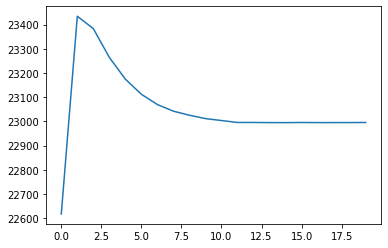

In [91]:
plt.plot([x[0] for x in da0])
#plt.semilogy([x[1].sum() for x in da0])


In [111]:
jax.grad(lambda x: fixed_point_solver_implicit(
    update,
    (x, dt, gram, XT_y, hyper_prior),
    prior_init,
    lambda z_prev, z: True,
    max_iter=1000)[0][0])(theta)[1]

DeviceArray([ 5.4155453e-04, -1.9167999e-06,  9.4835712e-03,
             -1.0984602e-05,  1.3721892e-01,  7.9632839e-05,
             -4.4852604e-05,  1.0960905e-04,  4.2508214e-05,
              1.1320165e-04,  1.0525882e-04, -6.4459644e-05],            dtype=float32)

In [ ]:
jax.value_and_grad()

In [57]:
jnp.arange(500, 2001, 100)

DeviceArray([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400,
             1500, 1600, 1700, 1800, 1900, 2000], dtype=int32)

In [61]:
da0

[DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(-4.7063775e+14, dtype=float32),
 DeviceArray(0.00058655, dtype=float32),
 DeviceArray(0.00059303, dtype=float32),
 DeviceArray(0.00059304, dtype=float32),
 DeviceArray(0.00059305, dtype=float32),
 DeviceArray(0.00059306, dtype=float32),
 DeviceArray(0.00059305, dtype=float32),
 DeviceArray(0.00059305, dtype=float32),
 DeviceArray(0.00059304, dtype=float32),
 DeviceArray(0.00059304, dtype=float32),
 DeviceArray(0.00059304, dtype=float32),
 DeviceArray(0.00059303, dtype=float32),
 DeviceArray(0.00059303, dtype=float32),
 DeviceArray(0.00059304, dtype=float32),
 DeviceArray(0.00059304, dtype=float32),
 DeviceArray(0.00059305, dtype=float32),
 DeviceArray(0.00059303, dtype=float32)]

In [53]:
jax.value_and_grad()

DeviceArray([[ 2.11049104e-04, -7.59726561e-07,  3.69585771e-03, ...,
               4.34676149e-05,  4.07630178e-05, -2.49507812e-05],
             [ 1.92724285e-04, -6.93761535e-07,  3.37495655e-03, ...,
               3.96934411e-05,  3.72236755e-05, -2.27843720e-05],
             [ 1.73356908e-04, -6.24043594e-07,  3.03579820e-03, ...,
               3.57045428e-05,  3.34829674e-05, -2.04947100e-05],
             ...,
             [ 5.36452513e-04, -1.93110145e-06,  9.39426944e-03, ...,
               1.10487614e-04,  1.03612962e-04, -6.34208336e-05],
             [ 5.24197589e-04, -1.88698641e-06,  9.17966291e-03, ...,
               1.07963584e-04,  1.01245983e-04, -6.19720158e-05],
             [ 5.12131257e-04, -1.84355065e-06,  8.96835979e-03, ...,
               1.05478415e-04,  9.89154432e-05, -6.05455098e-05]],            dtype=float32)

Let's try again with the SBL function:

In [42]:
%%time
jax.grad(lambda x: SBL(fixed_point_solver_implicit, x, dt, max_iter=1000)[2][0])(theta)

CPU times: user 451 ms, sys: 0 ns, total: 451 ms
Wall time: 449 ms


DeviceArray([[ 3.8704185e+01,  5.0534033e+03,  4.3851519e+03, ...,
               1.1056242e+06,  2.4217150e+05,  8.9219609e+03],
             [ 4.0451740e+01,  5.0363076e+03,  4.3802617e+03, ...,
               1.1020118e+06,  2.3915953e+05,  7.0822578e+03],
             [ 4.2372829e+01,  5.0155098e+03,  4.3732275e+03, ...,
               1.0976028e+06,  2.3573431e+05,  5.0412812e+03],
             ...,
             [ 1.0419348e+02,  1.5590066e+03,  1.8411733e+03, ...,
               3.4674603e+05, -3.3336469e+04, -8.6442672e+04],
             [ 1.0573392e+02,  1.5614191e+03,  1.8513120e+03, ...,
               3.4737412e+05, -3.4993594e+04, -8.7905984e+04],
             [ 1.0723337e+02,  1.5639131e+03,  1.8613002e+03, ...,
               3.4801706e+05, -3.6598469e+04, -8.9328906e+04]],            dtype=float32)

In [43]:
prior_params[:-1]

DeviceArray([1.2780477e+04, 1.3957587e+03, 5.8624229e+01, 7.8023638e+03,
             1.4603419e+00, 1.0492312e+02, 1.9199420e+02, 4.3870547e+02,
             1.3861768e+02, 1.2480178e+01, 2.1501799e+01, 4.6251446e+01],            dtype=float32)